In [1]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import pandas as pd
import itertools
import os
import ROOT
import datetime
from root_numpy import root2array, root2rec, tree2rec, array2root, tree2array
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.misc import factorial
plt.rcParams.update({'font.size': 20})

Welcome to JupyROOT 6.10/04


In [2]:
INFILE_ON = '/home/david/data/CRTveto/numi.root'
f_ON = ROOT.TFile(INFILE_ON)
f_ON.cd("crt")
t_ON = f_ON.Get("crt/trackdump")
df_ON = pd.DataFrame(tree2array(t_ON))
print df_ON.shape
list(df_ON)

INFILE_OF = '/home/david/data/CRTveto/extnumi.root'
f_OF = ROOT.TFile(INFILE_OF)
f_OF.cd("crt")
t_OF = f_OF.Get("crt/trackdump")
df_OF = pd.DataFrame(tree2array(t_OF))
print df_OF.shape
list(df_OF)

DTOFFSET = 68.6 # us

(38157, 39)
(58774, 39)


In [3]:
# optical precuts
PEMIN     = 50  # PE
BEAMSTART = 5.  # us
BEAMEND   = 16. # us

def OpticalPrecuts(x):
    
    nflash = x['nPMTflash']
    
    beamflashPE = x['beamflashPE']
    
    # remove events with flashes before the beam window opens
    time_flash_v = x['Timeflash']
    pe_flash_v   = x['PEflash']
    
    for n in xrange(nflash):
        if ( (time_flash_v[n] < BEAMSTART) and (pe_flash_v[n] > beamflashPE) ):
            return False
    
    return True

def MaxBeamFlash(x):
    
    nflash = x['nPMTflash']
    time_flash_v = x['Timeflash']
    pe_flash_v   = x['PEflash']
    
    # by default return -1 -> did not find beam flash
    nmax = -1
    
    maxflashT  = 0.
    maxflashPE = 0.
    
    for n in xrange(nflash):
        flash_time = time_flash_v[n]
        if (flash_time < BEAMSTART or flash_time > BEAMEND):
            continue
        flash_pe = pe_flash_v[n]
        if (flash_pe > maxflashPE):
            maxflashPE = flash_pe
            nmax = n
            
    return nmax

def MaxBeamFlashTime(x):
    return x['Timeflash'][x['beamflash']]

def MaxBeamFlashPE(x):
    return x['PEflash'][x['beamflash']]


df_ON['beamflash']     = df_ON.apply(lambda x : MaxBeamFlash(x),     axis=1)
df_ON['beamflashTime'] = df_ON.apply(lambda x : MaxBeamFlashTime(x), axis=1)
df_ON['beamflashPE']   = df_ON.apply(lambda x : MaxBeamFlashPE(x),   axis=1)
df_ON['precuts']       = df_ON.apply(lambda x : OpticalPrecuts(x),   axis=1)


df_OF['beamflash']     = df_OF.apply(lambda x : MaxBeamFlash(x),     axis=1)
df_OF['beamflashTime'] = df_OF.apply(lambda x : MaxBeamFlashTime(x), axis=1)
df_OF['beamflashPE']   = df_OF.apply(lambda x : MaxBeamFlashPE(x),   axis=1)
df_OF['precuts']       = df_OF.apply(lambda x : OpticalPrecuts(x),   axis=1)

In [4]:
# veto implementation

# only match the largest identified flash in the beam-spill window
def DtVeto(x):
    
    dtmin = 1e6
    dtrel = 1e6
    
    flashtime = x['beamflashTime']
    crttimes = np.array(x['hit_time0'])/1e3 + DTOFFSET
    nhits = x['nCRThits']
    
    for n in xrange(nhits):
        dt = flashtime - crttimes[n]
        if (np.abs(dt) < dtmin):
            dtmin = np.abs(dt)
            dtrel = dt
    
    return dtrel

def TopVeto(x):
    
    dtmin = 1e6
    dtrel = 1e6
    
    flashtime = x['beamflashTime']
    crttimes = np.array(x['hit_time0'])/1e3 + DTOFFSET
    nhits = x['nCRThits']
    Ypos  = x['hit_posy']
    
    for n in xrange(nhits):
        
        ypos = Ypos[n]
        if (ypos < 400.):
            continue
        
        dt = flashtime - crttimes[n]
        if (np.abs(dt) < dtmin):
            dtmin = np.abs(dt)
            dtrel = dt
            
    return dtrel

def LooseVeto(x):
    
    nflash = x['nPMTflash']
    time_flash_v = x['Timeflash']
    pe_flash_v   = x['PEflash']
    
    dtmin = 1e6
    dtrel = 1e6
    
    crttimes = np.array(x['hit_time0'])/1e3 + DTOFFSET
    nhits = x['nCRThits']
    
    # by default return -1 -> did not find beam flash
    nmax = -1
    
    maxflashT  = 0.
    maxflashPE = 0.
    
    for n in xrange(nflash):
        flash_time = time_flash_v[n]
        if (flash_time < BEAMSTART or flash_time > BEAMEND):
            continue
        # loop through CRT hits
        for n in xrange(nhits):
            dt = flash_time - crttimes[n]
            if (np.abs(dt) < dtmin):
                dtmin = np.abs(dt)
                dtrel = dt
                
    return dtrel

df_ON['dtcrt'] = df_ON.apply(lambda x : DtVeto(x), axis=1)
df_OF['dtcrt'] = df_OF.apply(lambda x : DtVeto(x), axis=1)

df_ON['dtcrtTOP'] = df_ON.apply(lambda x : TopVeto(x), axis=1)
df_OF['dtcrtTOP'] = df_OF.apply(lambda x : TopVeto(x), axis=1)

#df_ON['dtcrtloose'] = df_ON.apply(lambda x : LooseVeto(x), axis=1)
#df_OF['dtcrtloose'] = df_OF.apply(lambda x : LooseVeto(x), axis=1)

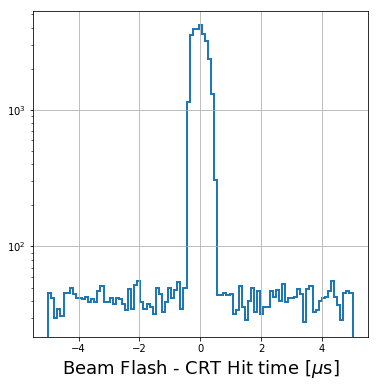

In [13]:
fig = plt.figure(figsize=(6,6))
plt.hist(df_OF['dtcrt'],bins=np.linspace(-5,5,100),histtype='step',lw=2)
plt.yscale('log')
plt.grid()
plt.xlabel('Beam Flash - CRT Hit time [$\mu$s]',fontsize=18)
plt.show()

In [5]:
n0_ON = df_ON.shape[0]
n0_OF = df_OF.shape[0]
df1_ON = df_ON.query('precuts == True')
df1_OF = df_OF.query('precuts == True')
n1_ON = df1_ON.shape[0]
n1_OF = df1_OF.shape[0]
df2_ON = df1_ON.query('beamflashPE > 20.')
df2_OF = df1_OF.query('beamflashPE > 20.')
n2_ON = df2_ON.shape[0]
n2_OF = df2_OF.shape[0]
df3_ON = df2_ON.query('dtcrtTOP < -1 or dtcrtTOP > 1')
df3_OF = df2_OF.query('dtcrtTOP < -1 or dtcrtTOP > 1')
n3_ON = df3_ON.shape[0]
n3_OF = df3_OF.shape[0]

def error(num,den):
    eff = float(num)/den
    return np.sqrt(eff*(1-eff)/(num+den))

print
print
print 'Optical Precuts OnBeam : %.03f +\- %.03f \t %.03f +\- %.03f'%(float(n1_ON)/n0_ON,error(n1_ON,n0_ON),float(n1_ON)/n0_ON,error(n1_ON,n0_ON))
print 'Optical Precuts OffBeam: %.03f +\- %.03f \t %.03f +\- %.03f'%(float(n1_OF)/n0_OF,error(n1_OF,n0_OF),float(n1_OF)/n0_OF,error(n1_OF,n0_OF))
print
print 'PE Cut OnBeam          : %.03f +\- %.03f \t %.03f +\- %.03f'%(float(n2_ON)/n1_ON,error(n2_ON,n1_ON),float(n2_ON)/n0_ON,error(n2_ON,n0_ON))
print 'PE Cut OffBeam         : %.03f +\- %.03f \t %.03f +\- %.03f'%(float(n2_OF)/n1_OF,error(n2_OF,n1_OF),float(n2_OF)/n0_OF,error(n2_OF,n0_OF))
print
print 'CRT veto OnBeam        : %.03f +\- %.03f \t %.03f +\- %.03f'%(float(n3_ON)/n2_ON,error(n3_ON,n2_ON),float(n3_ON)/n0_ON,error(n3_ON,n0_ON))
print 'CRT veto OffBeam       : %.03f +\- %.03f \t %.03f +\- %.03f'%(float(n3_OF)/n2_OF,error(n3_OF,n2_OF),float(n3_OF)/n0_OF,error(n3_OF,n0_OF))
print



Optical Precuts OnBeam : 0.902 +\- 0.001 	 0.902 +\- 0.001
Optical Precuts OffBeam: 0.898 +\- 0.001 	 0.898 +\- 0.001

PE Cut OnBeam          : 0.858 +\- 0.001 	 0.774 +\- 0.002
PE Cut OffBeam         : 0.825 +\- 0.001 	 0.741 +\- 0.001

CRT veto OnBeam        : 0.731 +\- 0.002 	 0.566 +\- 0.002
CRT veto OffBeam       : 0.658 +\- 0.002 	 0.487 +\- 0.002

